In [1]:
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.utils import np_utils
import keras

Using TensorFlow backend.


In [2]:
df = pd.read_csv('train_test.csv')
predict_df = pd.read_csv('predict.csv')
df2 = pd.read_csv('reboot_time.csv')
predict_reboot_df = pd.read_csv('reboot_time(predict).csv')

# setting sliding window size
minutes = 60
window_parameter = 60*minutes
window_size = int(window_parameter/30)

train_size = int(0.7*df.shape[0])  # number of timestamp to train from
test_size = int(0.3*df.shape[0]) # number of timestamp to be test from
n_epochs = 5
oversampling_type = 2
label_type = 2
model_type = 3
# filter_on = 1

In [3]:
predict_df

,collections(end of minor GC (Allocatin Failure)),process_cpu_usage,memory_usaged PS_Eden_Space,memory_usaged PS_Old_Gen,pause durations(avg end of minor GC (Allocation Failure)),pause durations(max end of minor GC (Allocation Failure)),thread(live),thread(daemon),thread(peak),tomcat_threads(busy),tomcat_threads(current),kafka_topic_offset,label
0,0.285714,0.414035,0.778477,0.155715,0.116250,0.127178,0.743243,0.660714,0.733333,0.25,1.0,0.499932,1
1,0.285714,0.421397,0.522069,0.155853,0.100000,0.127178,0.743243,0.660714,0.733333,0.25,1.0,0.499934,1
2,0.285714,0.394040,0.936700,0.155940,0.037500,0.127178,0.743243,0.660714,0.733333,0.25,1.0,0.499933,1
3,0.285714,0.414007,0.486989,0.156078,0.037000,0.127178,0.743243,0.660714,0.733333,0.25,1.0,0.499933,1
4,0.285714,0.402435,0.949867,0.156182,0.038750,0.015679,0.743243,0.660714,0.733333,0.25,1.0,0.499933,1
5,0.214286,0.409609,0.568275,0.156321,0.037000,0.015679,0.743243,0.660714,0.733333,0.25,1.0,0.499933,1
6,0.214286,0.417894,0.021895,0.156477,0.035000,0.015679,0.743243,0.660714,0.733333,0.25,1.0,0.499933,1
7,0.285714,0.414327,0.643335,0.156581,0.035000,0.015679,0.743243,0.660714,0.733333,0.25,1.0,0.499933,1
8,0.285714,0.402111,0.036616,0.156737,0.038000,0.015679,0.743243,0.660714,0.733333,0.25,1.0,0.499932,1
9,0.285714,0.398048,0.637063,0.156823,0.038750,0.015679,0.743243,0.660714,0.733333,0.25,1.0,0.499933,1


In [4]:
# extract all reboot index
reboot = df2['reboot'].values
predict_reboot = predict_reboot_df['reboot'].values

def extract_reboot_time(reboot):
    reboot_index = []
    for i,v in enumerate(reboot):
        if v == 1:
            reboot_index.append(i)
    return reboot_index

t1 = extract_reboot_time(reboot)
t2 = extract_reboot_time(predict_reboot)        
        

In [5]:
count_class_0, count_class_1,count_class_2 = df['label'].value_counts()
print(count_class_0, count_class_1, count_class_2)

ValueError: not enough values to unpack (expected 3, got 2)

In [6]:
# create model input/ouput data
y = df['label'].values
x_df = df.drop('label',axis=1)
x = x_df[::].values

truth = predict_df['label'].values
predict = predict_df.drop('label',axis = 1)
predict_data = predict[::].values

print(x.shape,type(x),len(x))
print(y.shape,type(y),len(y))
print(predict_data.shape,type(predict_data),len(predict_data))
print(truth.shape,type(truth),len(truth))


# from sklearn.decomposition import PCA
# pca = PCA(n_components=1)
# x_pca = pca.fit_transform(x)
# predict_data_pca = pca.fit_transform(predict_data)
# print("original shape:   ", x_pca.shape)
# print("transformed shape:", predict_data_pca.shape)


# create train / test
def create_train_test(df):
    train_set = df[0:train_size]
    test_set = df[train_size: train_size+test_size]
    return train_set, test_set

x_train, x_test = create_train_test(x)
y_train, y_test = create_train_test(y)


# handle imbalanced dataset by oversampling minority data
from imblearn.over_sampling import (RandomOverSampler, SMOTE, ADASYN)

if oversampling_type == 1:
    sm = RandomOverSampler(random_state=42)
elif oversampling_type == 2:
    sm = SMOTE(random_state=42)
    
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)
cnt1,cnt2,cnt3,cnt4 = 0, 0, 0, 0
for i in y_train_res:
    if i == 0:
        cnt1 += 1
    elif i == 1:
        cnt2 += 1
    elif i == 2:
        cnt3 += 1
    else:
        cnt4 += 1
print(cnt1,cnt2,cnt3,cnt4)

(28800, 12) <class 'numpy.ndarray'> 28800
(28800,) <class 'numpy.ndarray'> 28800
(8640, 12) <class 'numpy.ndarray'> 8640
(8640,) <class 'numpy.ndarray'> 8640
16742 16742 0 0


In [7]:
predict_data

array([[ 0.28571429,  0.41403479,  0.77847654, ...,  0.25      ,
         1.        ,  0.49993249],
       [ 0.28571429,  0.42139669,  0.52206898, ...,  0.25      ,
         1.        ,  0.49993351],
       [ 0.28571429,  0.3940405 ,  0.93670022, ...,  0.25      ,
         1.        ,  0.49993257],
       ..., 
       [ 0.35714286,  0.46199022,  0.46788987, ...,  0.25      ,
         1.        ,  0.49993485],
       [ 0.35714286,  0.53206198,  0.42949716, ...,  0.25      ,
         1.        ,  0.49993266],
       [ 0.28571429,  0.47699744,  0.45830856, ...,  0.25      ,
         1.        ,  0.50005106]])

In [8]:
print(len(x_train_res)) #number of sliding window in train
print(len(x_train_res[0])) # size of each sliding window
print(x_train_res)
print(y_train_res)
print('------------------------------------------------')
print(len(x_test)) #number of sliding window in train
print(len(x_test[0])) # size of each sliding window
print(x_test)
print(y_test)

33484
12
[[ 0.28571429  0.33934251  0.17329015 ...,  0.25        1.          0.49993253]
 [ 0.28571429  0.35510198  0.26795259 ...,  0.25        1.          0.49993286]
 [ 0.28571429  0.33537409  0.48008841 ...,  0.25        1.          0.49993253]
 ..., 
 [ 0.64285714  0.75179777  0.60126588 ...,  0.25        1.          0.49993443]
 [ 0.          0.          0.         ...,  0.          0.          0.49993307]
 [ 0.14285714  0.24607864  0.90582613 ...,  0.25        1.          0.49993233]]
[0 0 0 ..., 1 1 1]
------------------------------------------------
8640
12
[[ 0.35714286  0.52826287  0.86115771 ...,  0.25        1.          0.49993241]
 [ 0.42857143  0.5089795   0.08660378 ...,  0.25        1.          0.4999333 ]
 [ 0.42857143  0.49694205  0.17829714 ...,  0.25        1.          0.49993266]
 ..., 
 [ 0.5         0.49672479  0.02192614 ...,  0.25        1.          0.4999344 ]
 [ 0.42857143  0.48123087  0.31026916 ...,  0.25        1.          0.49993261]
 [ 0.42857143  0.500

In [9]:
# stroe temp value in comparison with y_pred
tmp_y_test = y_test

In [10]:
x_train_res = np.reshape(x_train_res, (x_train_res.shape[0],1,x_train_res.shape[1]))
x_test= np.reshape(x_test, (x_test.shape[0],1,x_test.shape[1]))

predict_data =  np.reshape(predict_data, (predict_data.shape[0],1,predict_data.shape[1]))

In [11]:
predict_data.shape

(8640, 1, 12)

In [12]:
# np.shape example
a = np.zeros([2,12])
print(a)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [13]:
# lSTM model types:
# each model performs at least 94% in f1-score:
if model_type == 1:
    # Single cell LSTM
    model = Sequential()
    model.add(LSTM(128,input_shape=(1, 12)))
    model.add(Dense(label_type,activation = 'sigmoid'))
if model_type == 2:
    # Stacked LSTM (3 cells)
    model = Sequential()
    model.add(LSTM(128,input_shape=(1, 12), return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(label_type, activation = 'sigmoid'))
if model_type == 3:
    # Bidirectional LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(128), input_shape=(1,12)))
    model.add(Dense(label_type,activation = 'sigmoid'))

In [14]:
if label_type > 2:
    model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
else:
    model.compile(optimizer = 'adam',loss = 'binary_crossentropy', metrics = ['accuracy'])

y_train_res = np_utils.to_categorical(y_train_res)
y_test = np_utils.to_categorical(y_test)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 256)               144384    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 144,898
Trainable params: 144,898
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
model.fit(x_train_res, y_train_res, validation_split = 0.2, epochs = n_epochs, batch_size = 32 ,verbose = 1)
score = model.evaluate(x_test,y_test)
print('test loss:', score[0])
print('test accuracy:',score[1])

Train on 26787 samples, validate on 6697 samples
Epoch 1/5
26787/26787 [==============================] - 14s 533us/step - loss: 0.4549 - acc: 0.7995 - val_loss: 0.5299 - val_acc: 0.7950
Epoch 2/5
26787/26787 [==============================] - 12s 437us/step - loss: 0.3307 - acc: 0.8761 - val_loss: 0.3694 - val_acc: 0.8363
Epoch 3/5
26787/26787 [==============================] - 11s 427us/step - loss: 0.3115 - acc: 0.8804 - val_loss: 0.3700 - val_acc: 0.8445
Epoch 4/5
26787/26787 [==============================] - 12s 430us/step - loss: 0.2972 - acc: 0.8842 - val_loss: 0.3562 - val_acc: 0.8527
Epoch 5/5
8640/8640 [==============================] - 1s 140us/step
test loss: 0.145639399859
test accuracy: 0.956423611111


In [16]:
# model Evaluation
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, accuracy_score, classification_report
y_pred = model.predict_classes(x_test)
print('check shape is equal or not:')
print(y_pred.shape)
print(tmp_y_test.shape,'\n')
print('confusion matrix:')
print(confusion_matrix(tmp_y_test,y_pred),'\n')
print('performance:')
print(classification_report(tmp_y_test,y_pred))

check shape is equal or not:
(8640,)
(8640,) 

confusion matrix:
[[7729  201]
 [ 175  535]] 

performance:
             precision    recall  f1-score   support

          0       0.98      0.97      0.98      7930
          1       0.73      0.75      0.74       710

avg / total       0.96      0.96      0.96      8640



In [17]:
# predict 07/27-0729 
pred = model.predict_classes(predict_data)
print(pred.shape)
print(truth.shape,'\n')
print(np.unique(pred))
print(np.unique(truth))



print('confusion matrix:')
print(confusion_matrix(truth,pred),'\n')
print('performance:')
print(classification_report(truth,pred))

# cause overfiiting problem --> 各個時段的離群值有所不同

(8640,)
(8640,) 

[0 1]
[0 1]
confusion matrix:
[[4546  282]
 [  91 3721]] 

performance:
             precision    recall  f1-score   support

          0       0.98      0.94      0.96      4828
          1       0.93      0.98      0.95      3812

avg / total       0.96      0.96      0.96      8640



In [18]:
time = np.arange(len(truth))

In [19]:
# Visualization
import matplotlib.pyplot as plt
def masked_plot(time,value,title="", xlabel='Time', ylabel='Value', dpi=200):
    plt.figure(figsize=(16,6), dpi=dpi)
    masked = np.ma.masked_equal(value, 1)
    masked2 = np.ma.masked_equal(value, 0)
    plt.plot(masked2, color='tab:green', linewidth=2)
    plt.plot(masked, color= 'red', linewidth=2)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
def plotting(time,value,code,title="", xlabel='Time', ylabel='Value', dpi=200):
    if code == 'truth':
        plt.figure(figsize=(16,8), dpi=dpi)
        plt.scatter(time,value, color='tab:green', linewidth=0.5)
        plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    elif code == 'pred':
        plt.figure(figsize=(16,8), dpi=dpi)
        plt.scatter(time,value, color='tab:green', linewidth=0.5)
        plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
    
    
def marker_plot(time,value,title="", xlabel='Time', ylabel='Value', dpi=200):
    
    plt.figure(figsize=(16,8), dpi=dpi)
    plt.plot(time, value, color='tab:orange')
    # Add below threshold markers
    below_threshold = y < 1
    plt.scatter(time[below_threshold], value[below_threshold], color='tab:green') 
    
    # Add above threshold markers
    above_threshold = np.logical_not(below_threshold)
    plt.scatter(time[above_threshold], value[above_threshold], color='r')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [20]:
# masked_plot(time,truth, title= 'mip-svc-push-notify-counter(0727-0729)')
# masked_plot(time,pred, title= 'mip-svc-push-notify-counter(0727-0729)')


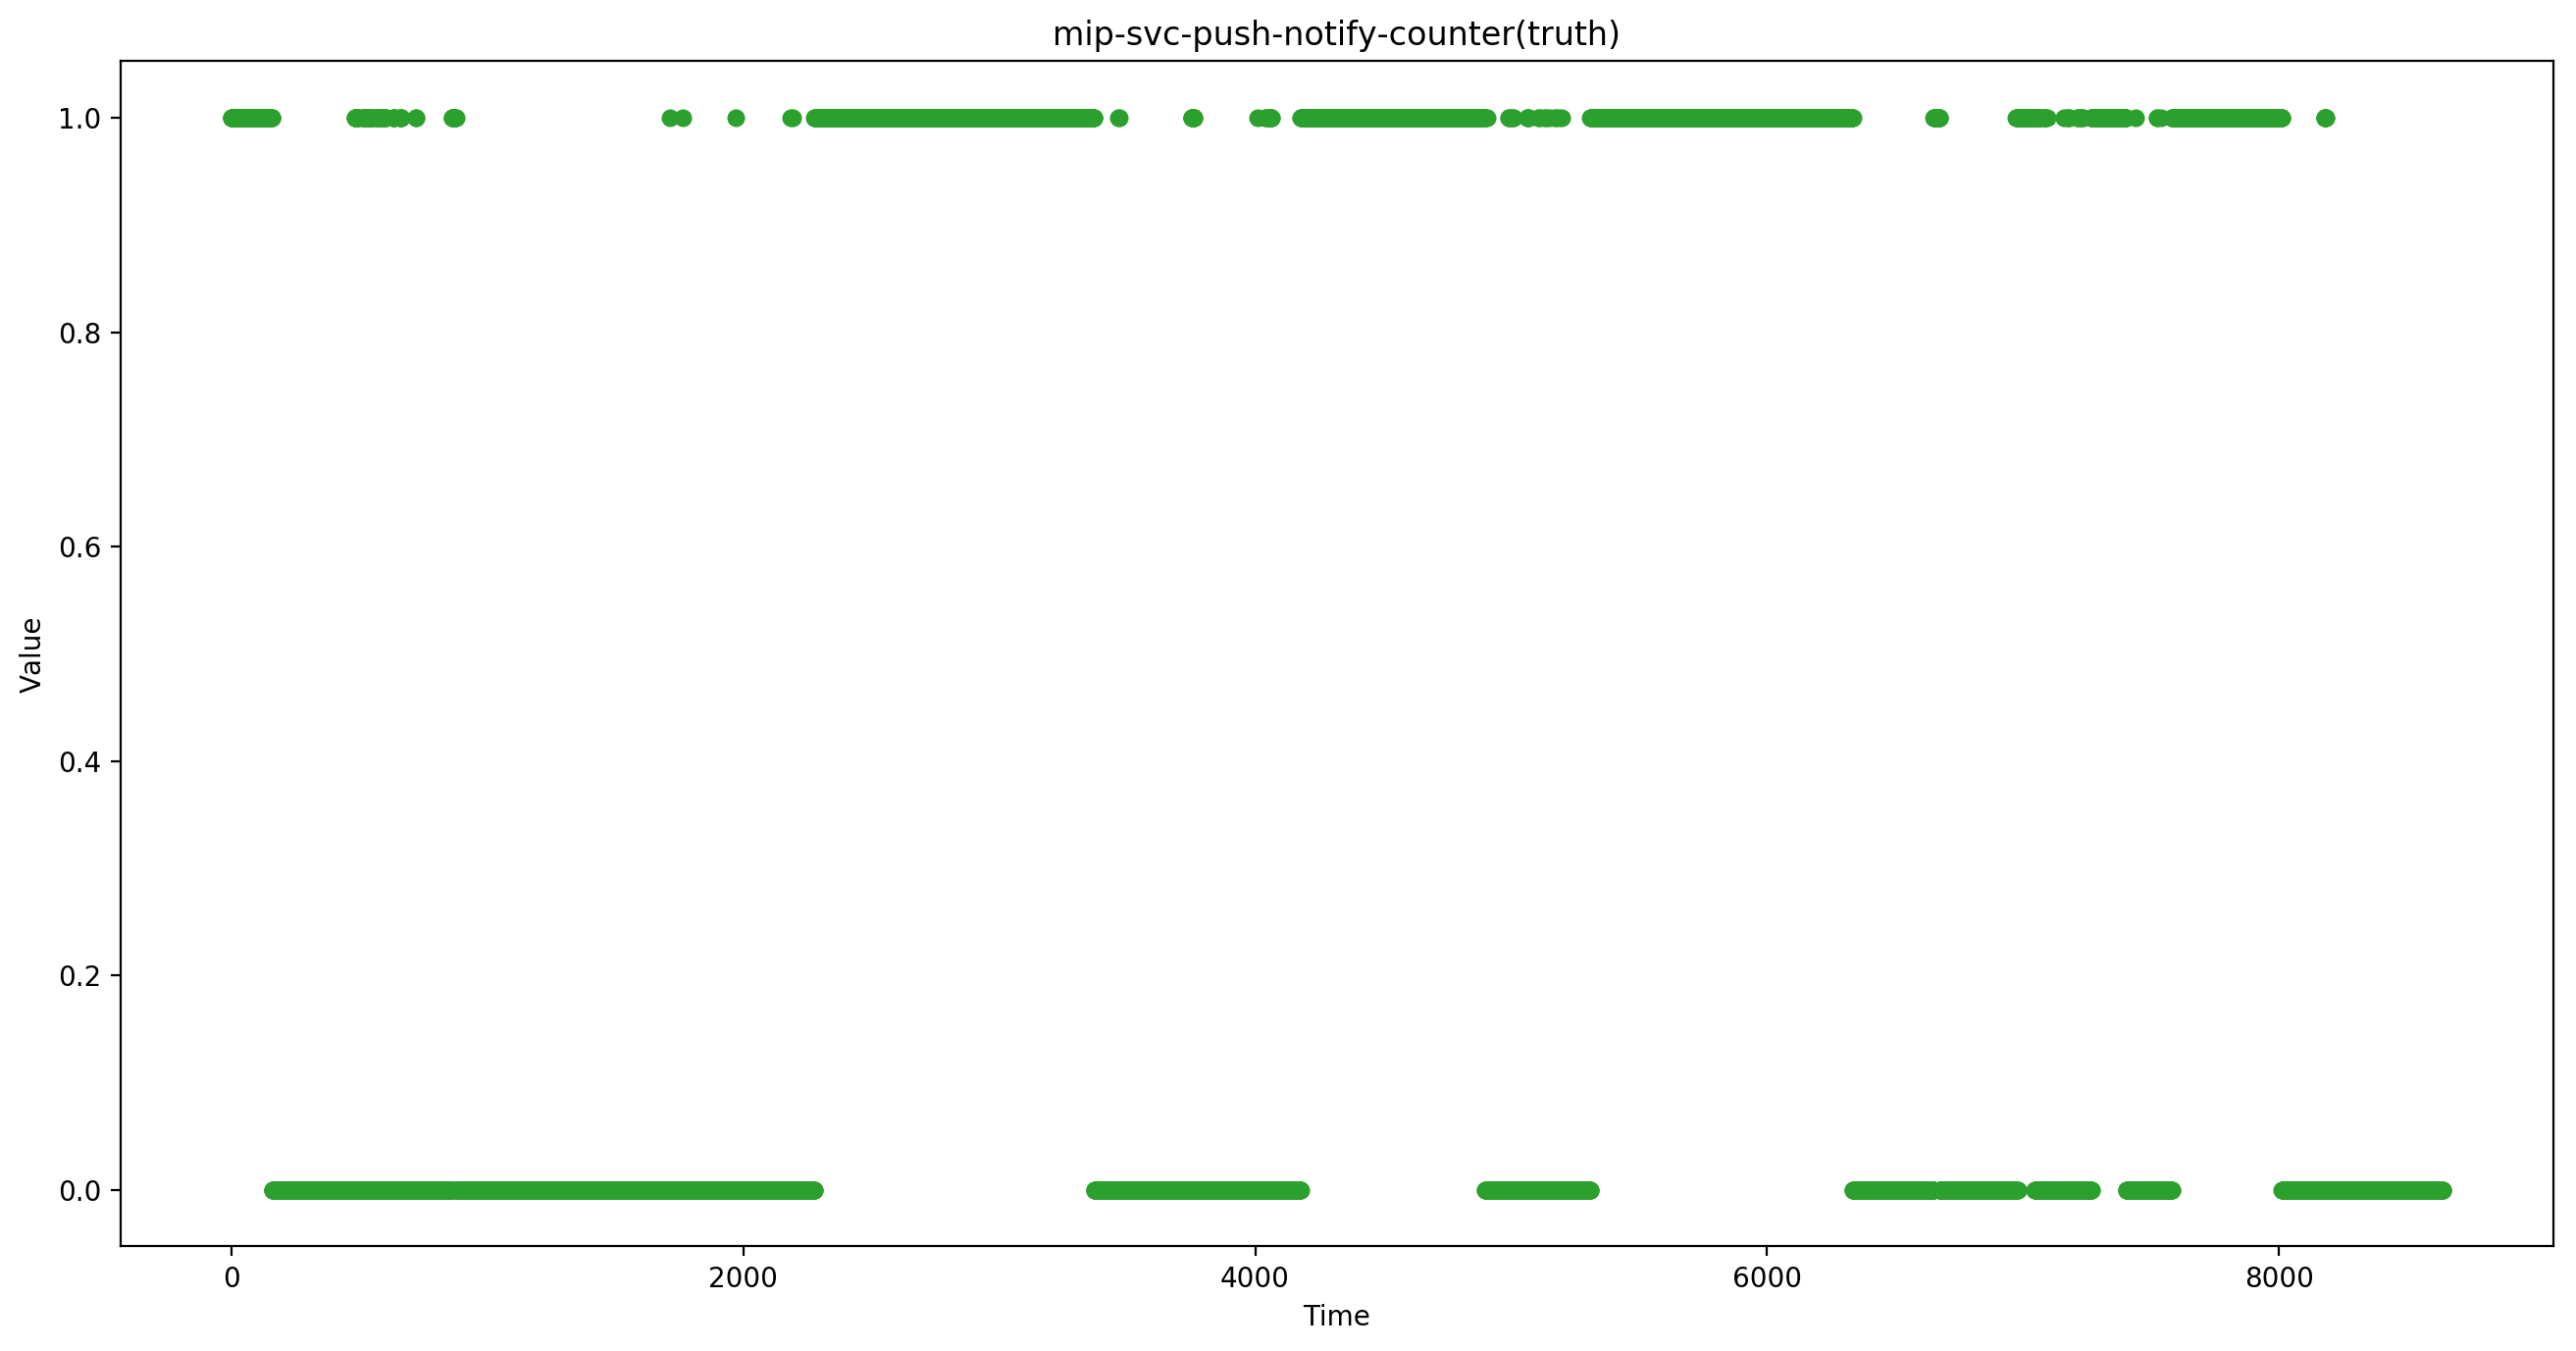

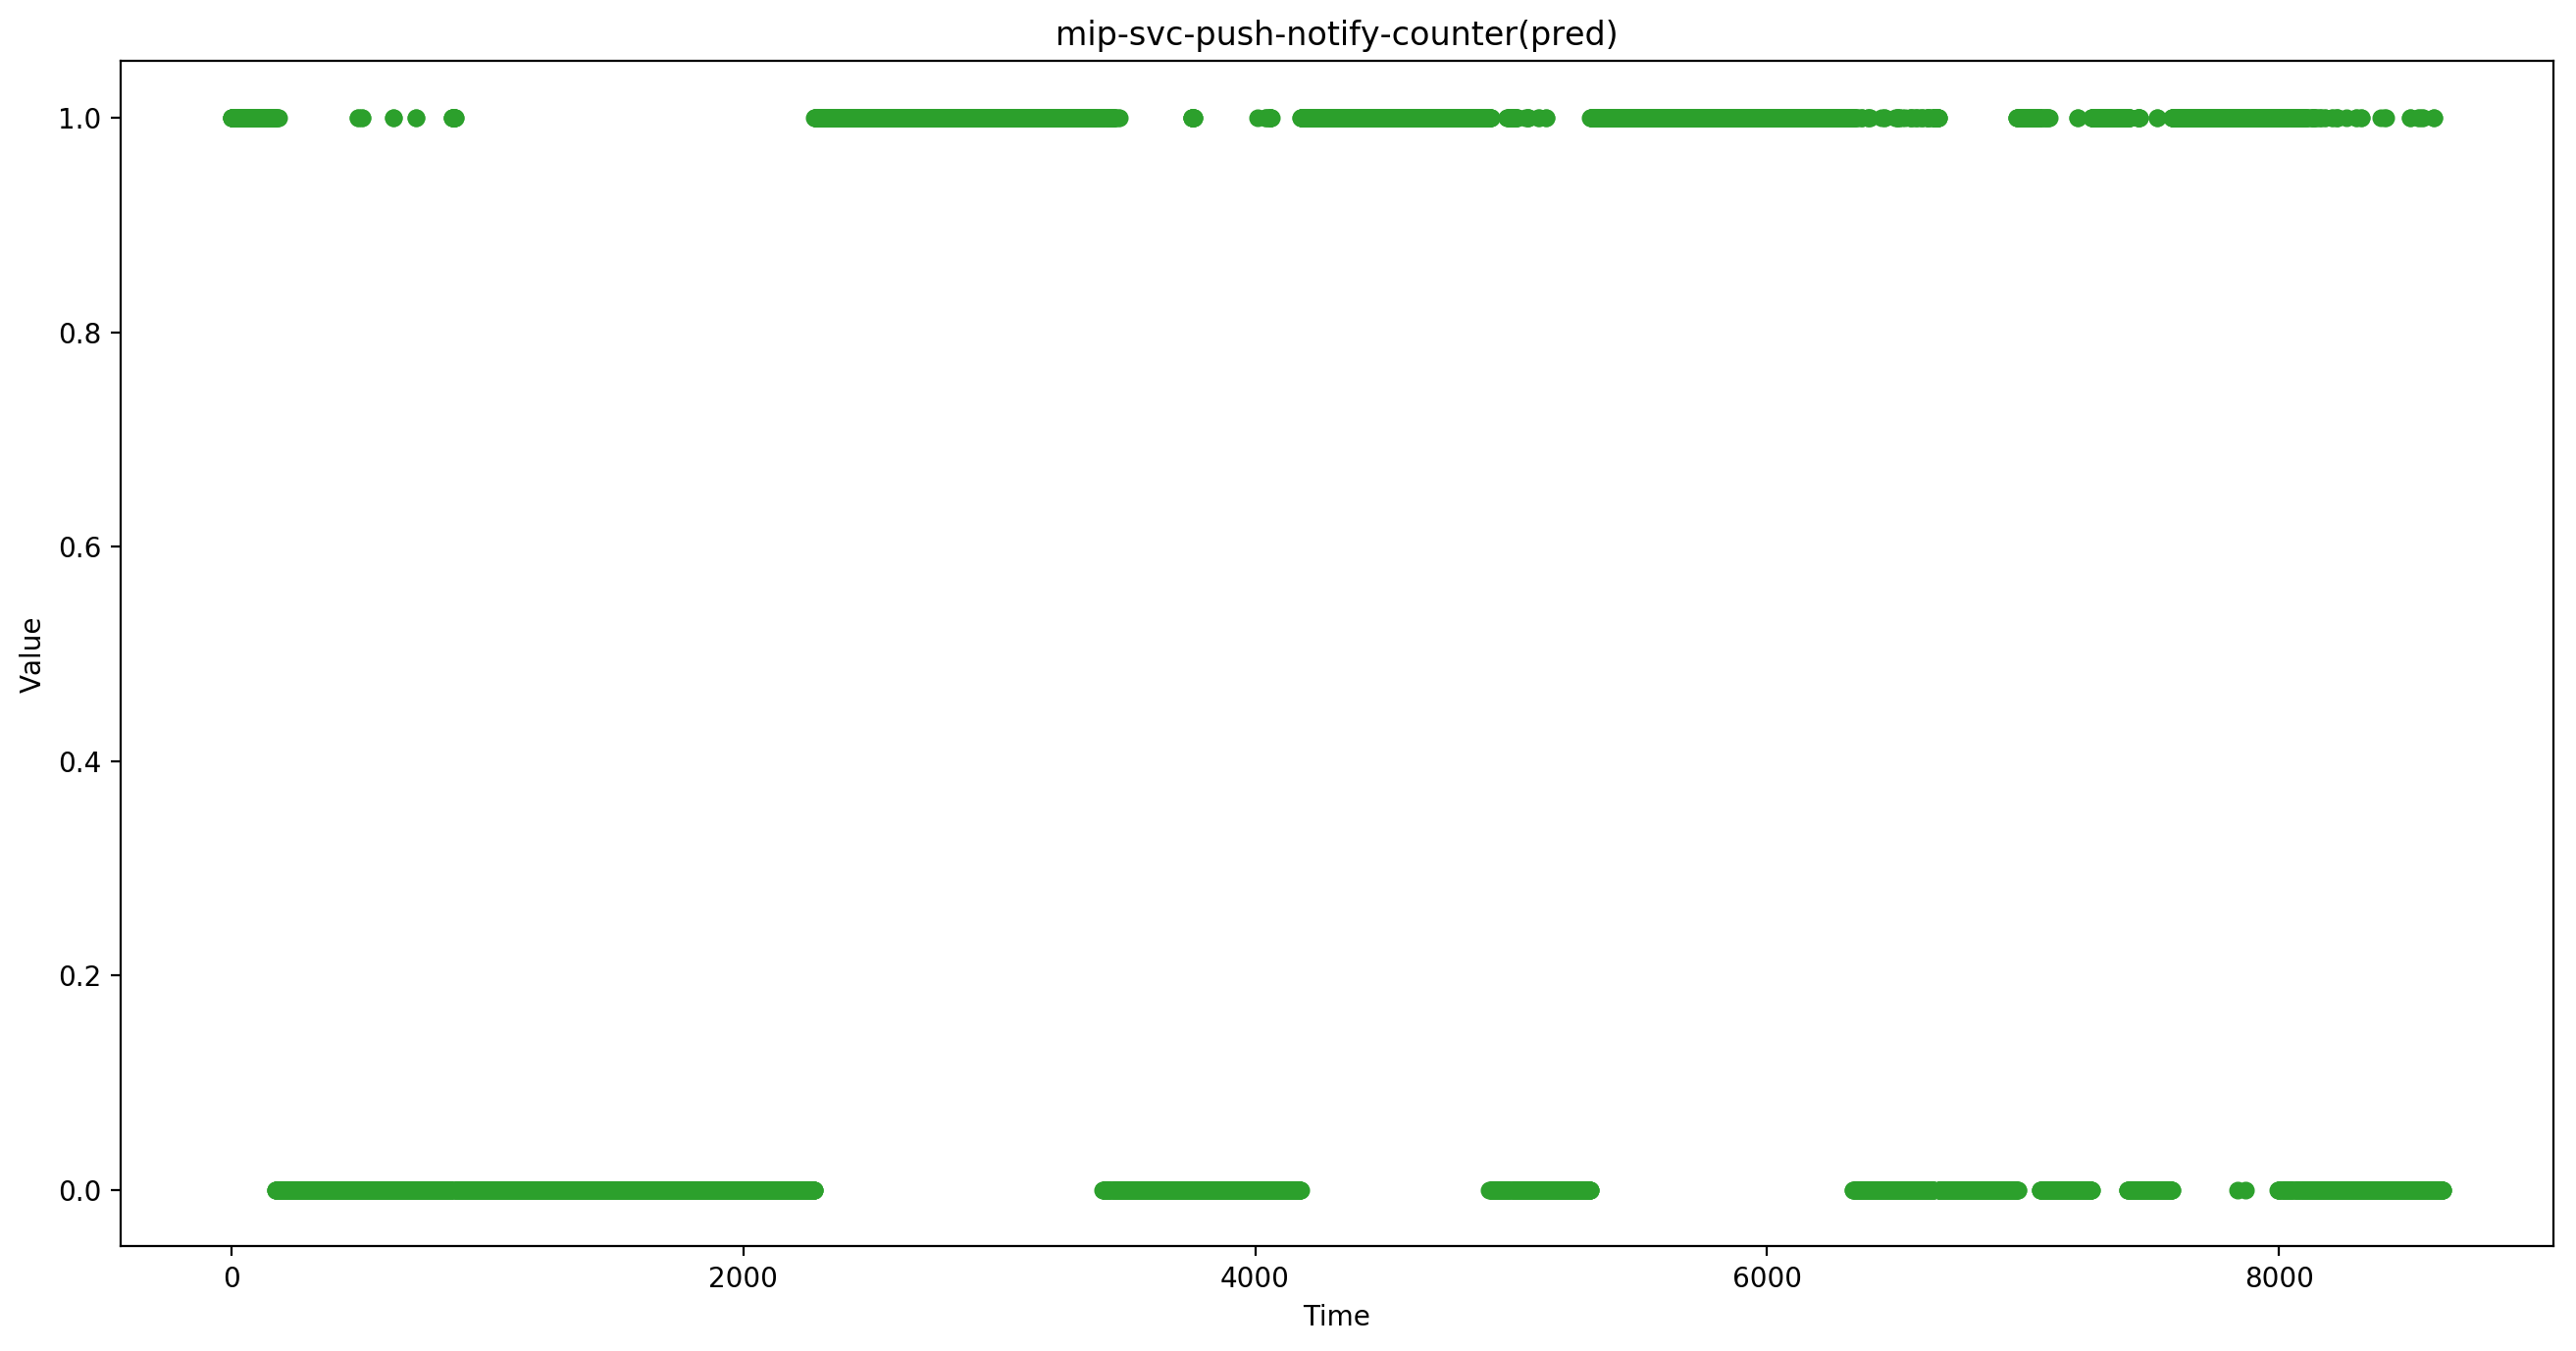

In [21]:
plotting(time,truth, code = 'truth', title= 'mip-svc-push-notify-counter(truth)')
plotting(time,pred, code = 'pred', title= 'mip-svc-push-notify-counter(pred)')